# MoodCraft: A Responsive Mental Health Chatbot with Emotion Recognition for Personalized Support and Crisis Intervention


In [1]:
import os, sys, random, time, datetime, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Read Dataset

In [3]:
def read_txt(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath, sep=';', header=None, names=['sentence', 'label'])
    df['label'] = df['label'].astype('category').cat.codes
    return df

train_df = read_txt('train.txt')
valid_df = read_txt('val.txt')
test_df  = read_txt('test.txt')

label_names = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df['label']),  y=train_df['label'])

train set



,sentence,label
0,i didnt feel humiliated,4
1,i can go from feeling so hopeless to so damned...,4
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,3
4,i am feeling grouchy,0


train_df.shape=(16000, 2)


<BarContainer object of 6 artists>

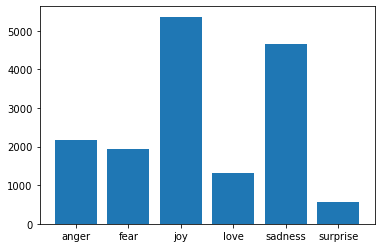

In [7]:
display(train_df.head(5))
print(f'{train_df.shape=}')
plt.bar(x=label_names, height=np.bincount(train_df['label']))

validation set

,sentence,label
0,im feeling quite sad and sorry for myself but ...,4
1,i feel like i am still looking at a blank canv...,4
2,i feel like a faithful servant,3
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,2


valid_df.shape=(2000, 2)


<BarContainer object of 6 artists>

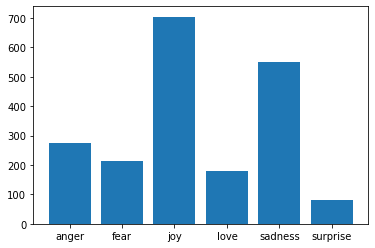

In [8]:
display(valid_df.head(5))
print(f"{valid_df.shape=}")
plt.bar(x=label_names, height=np.bincount(valid_df['label']))

test set

,sentence,label
0,im feeling rather rotten so im not very ambiti...,4
1,im updating my blog because i feel shitty,4
2,i never make her separate from me because i do...,4
3,i left with my bouquet of red and yellow tulip...,2
4,i was feeling a little vain when i did this one,4


test_df.shape=(2000, 2)


<BarContainer object of 6 artists>

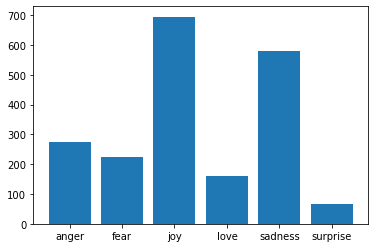

In [9]:
display(test_df.head(5))
print(f'{test_df.shape=}')
plt.bar(x=label_names, height=np.bincount(test_df['label']))

# Preprocess text


In [10]:
def clean_lemmatize_tokenize(text: str) -> list[str]:
      
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')    # add/remove regex as required
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    NUMBERS = re.compile('\d+')
    STOPWORDS = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # clean
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = NUMBERS.sub('', text)

    # remove stopwords and lemmatize
    tokens = [word for word in text.split() if word not in STOPWORDS]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
    return tokens
    
train_df['tokenized'] = train_df['sentence'].apply(clean_lemmatize_tokenize)
valid_df['tokenized'] = valid_df['sentence'].apply(clean_lemmatize_tokenize)
test_df['tokenized']  =  test_df['sentence'].apply(clean_lemmatize_tokenize)

In [11]:
train_df

,sentence,label,tokenized
0,i didnt feel humiliated,4,"[didnt, feel, humiliated]"
1,i can go from feeling so hopeless to so damned...,4,"[go, feeling, hopeless, damned, hopeful, aroun..."
2,im grabbing a minute to post i feel greedy wrong,0,"[im, grabbing, minute, post, feel, greedy, wrong]"
3,i am ever feeling nostalgic about the fireplac...,3,"[ever, feeling, nostalgic, fireplace, know, st..."
4,i am feeling grouchy,0,"[feeling, grouchy]"
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,"[brief, time, beanbag, said, anna, feel, like,..."
15996,i am now turning and i feel pathetic that i am...,4,"[turning, feel, pathetic, still, waiting, tabl..."
15997,i feel strong and good overall,2,"[feel, strong, good, overall]"
15998,i feel like this was such a rude comment and i...,0,"[feel, like, rude, comment, im, glad]"


In [12]:
def make_vocabulary_from_tokens(
    tokenized_sentences: pd.Series, 
    min_doc_freq: int = 1,
    max_doc_freq: int = 1_000_000
) -> dict[str: int]:
     
    # Count frequency of each token in dataset
    document_freq = {}
    for tokenized_sentence in tokenized_sentences:
        for token in tokenized_sentence:
            document_freq[token] = document_freq.get(token, 0) + 1
    
    # Discard tokens with freq < min_doc_freq
    qualified_tokens = {
        token: freq for token, freq in document_freq.items() if (min_doc_freq < freq < max_doc_freq)
    }
    
    # Add in token_ids for each token
    vocab = {token: token_id+2 for token_id, token in enumerate(qualified_tokens.keys())}
    
    # Add special tokens
    vocab['[PAD]'] = 0
    vocab['[UNK]'] = 1
    
    return vocab, qualified_tokens

vocab, doc_freq = make_vocabulary_from_tokens(train_df['tokenized'], 3)    # use only train set for this
print(f'{len(vocab)=}')

len(vocab)=3814


In [13]:
def tokens_to_input_ids(tokenized_sentence: list[str], vocabulary=vocab) -> torch.tensor:
    input_ids = [
        vocabulary.get(token, 1) for token in tokenized_sentence
    ]
    return input_ids

X_train, y_train = train_df['tokenized'].apply(tokens_to_input_ids), train_df['label'].to_list()
X_valid, y_valid = valid_df['tokenized'].apply(tokens_to_input_ids), valid_df['label'].to_list()
X_test,  y_test  =  test_df['tokenized'].apply(tokens_to_input_ids),  test_df['label'].to_list()

# Model

In [42]:
# Hyper parameters etc.
class CFG:
    n_epochs = 50
    learning_rate = 1.0e-3
    batch_size = 64
    batches_per_epoch = len(X_train) // batch_size
    label_names = [name[:3] for name in label_names]   # first few letters only for plots etc
    

class LSTMClassifier(nn.Module):
    
    def __init__(self):
        # Model parameters
        vocab_size = len(vocab)
        n_labels = len(label_names)
        embedding_dim = 256
        hidden_dim = 128
        dropout_rate = 0.25
        lstm_dropout_rate = 0.2,
        num_lstm_layers = 1

        # Model
        super().__init__()
        self.n_layers = num_lstm_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, num_layers=num_lstm_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, n_labels)
    
    def forward(self, X_batch):
        embedding = self.dropout(self.embedding(X_batch))
        hidden, carry = (
            torch.randn(self.n_layers, len(X_batch), self.hidden_dim), 
            torch.randn(self.n_layers, len(X_batch), self.hidden_dim),
        )
        output, (hidden, carry) = self.lstm(embedding, (hidden, carry))
        return self.fc(self.dropout(output[:,-1]))

In [43]:
model = LSTMClassifier()
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))   # adding class weights because unbalanced train set
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)

def weighted_f1(y_true, y_pred):
    return f1_score(y_true.argmax(1), y_pred.argmax(1), average='weighted')

In [44]:
class TextDataset(Dataset):
    def __init__(self, input_ids: list[list[int]], labels: list[int]):
        self.input_ids = pad_sequence([torch.tensor(sequence) for sequence in input_ids], batch_first=True)
        self.labels = nn.functional.one_hot(torch.tensor(labels)).to(torch.float)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return [self.input_ids[idx], self.labels[idx]]
    
def collate_fn(batch):
    pass

# Train and Validate Model

In [45]:
def train_model(
    X_train, y_train,
    X_valid, y_valid,
    model, optimizer, metric, loss_fn, collate_fn, CFG,
):
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    train_loss  = []; valid_loss  = []
    train_score = []; valid_score = []
    
    train_loader  = DataLoader(
        TextDataset(X_train, y_train), 
        batch_size=CFG.batch_size, collate_fn=collate_fn, shuffle=True
    )
    valid_loader  = DataLoader(
        TextDataset(X_valid, y_valid),
        batch_size=CFG.batch_size, collate_fn=collate_fn, shuffle=False
    )
    
    best_vloss = 1_000_000
    
    for epoch in range(CFG.n_epochs):
        
        # Train step
        model.train(True)
        running_loss = 0
        running_score = 0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # compute metrics and store
            score = metric(labels, outputs)
            running_score += score
            running_loss += loss.item()
            
        train_score.append(avg_score := float(score / (i + 1)))
        train_loss.append(avg_loss := float(loss / (i + 1)))
        # TODO: find way to make these numbers bigger for plotting    
            
        # Validate
        model.eval()
        running_vloss = 0
        running_vscore = 0
        with torch.no_grad():
            for i, vdata in enumerate(valid_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                
                vscore = metric(vlabels, voutputs)
                running_vscore += vscore
                running_vloss += vloss
                
        valid_score.append(avg_vscore := float(running_vscore / (i + 1)))
        valid_loss.append(avg_vloss := float(running_vloss / (i + 1)))
        
        
        # Track best performance and save model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)
            
        print(f'Epoch {epoch}: loss = {avg_loss} score = {avg_score} | vloss = {avg_vloss} vscore = {avg_vscore}')
                
            
    # Plot loss and metric
    fig,(ax1, ax2) = plt.subplots(1, 2)
            
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss'); ax1.set_title('training loss')
    ax1.plot(np.arange(len(train_loss)), train_loss, label='training')
    ax1.plot(np.arange(len(valid_loss)), valid_loss, label='validation')
    ax1.legend()
    
    ax2.set_xlabel('epoch'); ax2.set_ylabel('score'); ax2.set_title('training score')
    ax2.plot(np.arange(len(train_score)), train_score, label='training')
    ax2.plot(np.arange(len(valid_score)), valid_score, label='validation')
    ax2.legend()
    

Epoch 0: loss = 0.007655714895966458 score = 0.0006020327085830517 | vloss = 1.828724231667646 vscore = 0.005486358002009394
Epoch 1: loss = 0.005959783641298939 score = 0.0014891098484848485 | vloss = 1.8290408650740435 vscore = 0.12050233415030033
Epoch 2: loss = 0.0070599220942746625 score = 1.923076923076923e-06 | vloss = 1.8281283304179303 vscore = 0.004548858002009394
Epoch 3: loss = 0.006590365162942845 score = 0.0006953828828828828 | vloss = 1.8295557392476227 vscore = 0.004548858002009394
Epoch 4: loss = 0.008072231069554753 score = 0.0008148427134011499 | vloss = 1.8299973059175743 vscore = 0.12165575848639416
Epoch 5: loss = 0.007687672110526221 score = 7.405462184873949e-05 | vloss = 1.829867936347903 vscore = 0.023529956543753672
Epoch 6: loss = 0.007397997598180843 score = 0.00014285714285714287 | vloss = 1.8295641082314942 vscore = 0.02666135396604472
Epoch 7: loss = 0.007726122038132342 score = 0.0006509046052631578 | vloss = 1.6731428600066443 vscore = 0.22447914280339

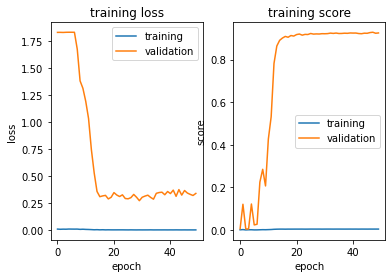

In [46]:
train_model(
    X_train, y_train,
    X_valid, y_valid,
    model, optimizer, weighted_f1, loss_fn, None, CFG
)

# Test Model

In [47]:
def test_model(X, y, model):
    
    model.eval()
    
    test_loader = DataLoader(
        TextDataset(X, y),
        batch_size=CFG.batch_size, shuffle=False
    )
    
    y_preds = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = model(inputs)
            y_preds.append(outputs.argmax(1))
            
    y_preds = torch.cat(y_preds)
    y_tensor = torch.tensor(y)
    accuracy = torch.sum(y_preds == y_tensor).item() / len(y)
    print(f"Testing Accuracy: {accuracy:.4f}")
    
    print(classification_report(y, y_preds, target_names=label_names))
    ConfusionMatrixDisplay.from_predictions(y, y_preds, display_labels=label_names)
    
    return y_preds

Testing Accuracy: 0.9285
              precision    recall  f1-score   support

       anger       0.93      0.93      0.93       275
        fear       0.90      0.86      0.88       212
         joy       0.95      0.93      0.94       704
        love       0.84      0.92      0.88       178
     sadness       0.96      0.96      0.96       550
    surprise       0.82      0.89      0.85        81

    accuracy                           0.93      2000
   macro avg       0.90      0.91      0.91      2000
weighted avg       0.93      0.93      0.93      2000



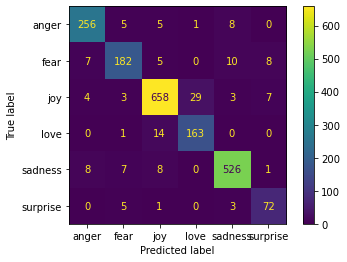

In [48]:
vpreds = test_model(X_valid, y_valid, model)

# Testing

In [68]:
# Test on some input sentences
input_sentences = [
    "I am so happy right now!",
"This is outrageous! I demand an explanation!",
"Spending time with loved ones fills my heart with happiness.",
    "Feeling lonely and isolated, I yearn for companionship.",
"Receiving a gift out of the blue left me pleasantly surprised."
]

tokenized_inputs = [clean_lemmatize_tokenize(sentence) for sentence in input_sentences]
input_ids = [tokens_to_input_ids(tokens, vocabulary=vocab) for tokens in tokenized_inputs]

model.eval()
with torch.no_grad():
    for i, input_id in enumerate(input_ids):
        input_tensor = torch.tensor(input_id).unsqueeze(0)
        output = model(input_tensor)
        predicted_label = label_names[output.argmax(1).item()]
        print("Sentence ",i+1,":")
        print(f"'{input_sentences[i]}' ")
        print("Predicted Emotion:", predicted_label)
        print("\n")

Sentence  1 :
'I am so happy right now!' 
Predicted Emotion: joy


Sentence  2 :
'This is outrageous! I demand an explanation!' 
Predicted Emotion: sadness


Sentence  3 :
'Spending time with loved ones fills my heart with happiness.' 
Predicted Emotion: joy


Sentence  4 :
'Feeling lonely and isolated, I yearn for companionship.' 
Predicted Emotion: sadness


Sentence  5 :
'Receiving a gift out of the blue left me pleasantly surprised.' 
Predicted Emotion: surprise


